# Машинное обучение, ФКН ВШЭ

# Практическое задание 7. Бустинг и бэггинг

## Общая информация
Дата выдачи: 08.12.2020

Мягкий дедлайн: 19.12.2020 00:59 MSK

Жёсткий дедлайн: 21.12.2020 00:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг. Работать мы будем на двух наборах данных: многомерных данных по кредитам с kaggle и синтетических двумерных. В данных с kaggle целевая переменная показывает, вернуло ли кредит физическое лицо:

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression

In [2]:
!wget  -O 'bank_data.csv' -q 'https://www.dropbox.com/s/uy27mctxo0gbuof/bank_data.csv?dl=0'

zsh:1: command not found: wget


In [3]:
df = pd.read_csv('bank_data.csv')
df.sample(5)

age           job  marital          education  default housing loan  \
9018   49  entrepreneur  married        high.school       no      no   no   
1815   38    unemployed   single        high.school       no     yes   no   
848    50    management  married  university.degree  unknown     yes   no   
6514   38   blue-collar  married           basic.9y       no      no   no   
8253   35        admin.  married  university.degree       no      no   no   

       contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
9018  cellular   may         tue  ...         1    999         0  nonexistent   
1815  cellular   dec         fri  ...         4      6         1      success   
848   cellular   aug         mon  ...         4    999         0  nonexistent   
6514  cellular   nov         thu  ...         1    999         0  nonexistent   
8253  cellular   jul         wed  ...         2    999         0  nonexistent   

     emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y  
9018         -1.8          92.893          -46.2      1.344       5099.1 -1  
1815         -3.0          92.713          -33.0      0.710       5023.5  1  
848           1.4          93.444          -36.1      4.965       5228.1  1  
6514         -0.1          93.200          -42.0      4.076       5195.8 -1  
8253          1.4          93.918          -42.7      4.963       5228.1  1  

[5 rows x 21 columns]

Разделим на train и test (random_state не меняем)

In [4]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

Генерируем синтетические данные (seed не меняем)

In [5]:
np.random.seed(42)

num_obs = 10 ** 5
num_thresholds = 50

X_synthetic = np.random.normal(scale=3, size=[num_obs, 2])
x1_thresholds = np.random.choice(X_synthetic[:, 0], num_thresholds, False)
x2_thresholds = np.random.choice(X_synthetic[:, 1], num_thresholds, False)

gains = np.random.uniform(-0.4086, 0.5, size=[2 * num_thresholds, 1])
x1_thresholds_cond = [X_synthetic[:, 0] >= threshold for threshold in x1_thresholds]
x2_thresholds_cond = [X_synthetic[:, 1] >= threshold for threshold in x2_thresholds]

noise = np.random.uniform(-0.5, 0.5, size=num_obs)

y_synthetic_probits = np.sum(
    gains[:num_thresholds] * x1_thresholds_cond + gains[num_thresholds:] * x2_thresholds_cond, axis=0
) + noise
y_synthetic = np.sign(y_synthetic_probits)

X_train_synthetic, y_train_synthetic = X_synthetic[:int(num_obs * 0.8)], y_synthetic[:int(num_obs * 0.8)]
X_test_synthetic, y_test_synthetic = X_synthetic[int(num_obs * 0.8):], y_synthetic[int(num_obs * 0.8):]

px.histogram(x = y_synthetic_probits, nbins=100)

Некоторый полезный код для визуализации предсказаний (пригодится позже)

In [6]:
import matplotlib.pyplot as plt

def plot_predicts(model, features, targets, x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0],
                  examples_density=0.01, steps=1000, num_ticks=6, title='', mode='classification'):
    '''
    Функция для визуализации предсказаний модели на двухмерной плоскости
    param model: обученная модель классификации или регрессии для двухмерных объектов
    param features: признаки выборки (a.k.a. X)
    param targets: целевая переменная выборки (a.k.a y)
    param x_lim: пределы для x
    param y_lim: пределы для y
    param examples_density: доля выборки, которая будет нарисована
    param steps: частота разбиения плоскости
    param num_ticks: число подписей на графике
    param title: заголовок графика
    param mode: режим 'classification' - вероятности положительного класса
                режим 'regression' - вещественная целевая переменная
    '''
    
    mask = np.random.choice([True, False], size=features.shape[0], 
                            p=[examples_density, 1.0 - examples_density])
    features_x = (features[mask, 0] - x_lim[0]) / (x_lim[1] - x_lim[0]) * steps
    features_y = (features[mask, 1] - y_lim[0]) / (y_lim[1] - y_lim[0]) * steps
    
    xs = np.linspace(x_lim[0], x_lim[1], steps)
    ys = np.linspace(y_lim[0], y_lim[1], steps)
    
    xs, ys = np.meshgrid(xs, ys)
    grid = np.stack([xs.flatten(), ys.flatten()], axis=1)
    if mode == 'classification':
        predicts = model.predict_proba(grid)[:, 1].reshape(steps, steps)
        values = (targets[mask] == 1).astype(np.float)
    elif mode == 'regression':
        predicts = model.predict(grid).reshape(steps, steps)
        values = targets[mask]
    else:
        raise ValueError('Unknown mode')
    
    plt.figure(figsize=(10, 10))
    plt.imshow(predicts, origin='lower')
    plt.scatter(features_x, features_y, c=values, edgecolors='white', linewidths=1.5)
    plt.colorbar()
    
    plt.xticks(np.linspace(0, steps, num_ticks), np.linspace(x_lim[0], x_lim[1], num_ticks))
    plt.yticks(np.linspace(0, steps, num_ticks), np.linspace(y_lim[0], y_lim[1], num_ticks))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid()
    plt.show()

#### 1. (4 балла) Реализуйте бустинг для задачи бинарной классификации.

Поскольку градиентный бустинг обучается через последовательное создание моделей, может получиться так, что оптимальная с точки зрения генерализации модель будет получена на промежуточной итерации. Обычно для контроля такого поведения в методе `fit` передается также валидационная выборка, по которой можно оценивать общее качество модели в процессе обучения (желательно делать это каждую итерацию, но если ваша имплементация слишком медленная или ваше железо не тянет, можно делать это реже). Кроме того, нет смысла обучать действительно глубокую модель на 1000 деревьев и больше, если оптимальный ансамбль получился, к примеру, на 70 итерации и в течение какого-то количества итераций не улучшился - поэтому мы также задействуем early stopping при отсутствии улучшений в течение некоторого числа итераций.

In [7]:
from scipy.special import logit
class Boosting:
    
    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: dict={'max_features': 0.1},
        n_estimators: int=10,
        learning_rate: float=0.1,
        subsample: float=0.3,
        random_seed: int=228,
        custom_loss: list or tuple=None,
        use_best_model: bool=False,
        n_iter_early_stopping: int=None
    ):
        
        # Класс базовой модели
        self.base_model_class = base_model_class
        # Параметры для инициализации базовой модели
        self.base_model_params = base_model_params
        # Число базовых моделей
        self.n_estimators = n_estimators
        # Длина шага (которая в лекциях обозначалась через eta)
        self.learning_rate = learning_rate
        # Доля объектов, на которых обучается каждая базовая модель
        self.subsample = subsample
        # seed для бутстрапа, если хотим воспроизводимость модели
        self.random_seed = random_seed
        # Использовать ли при вызове predict и predict_proba лучшее
        # с точки зрения валидационной выборки число деревьев в композиции
        self.use_best_model = use_best_model
        # число итераций, после которых при отсутствии улучшений на валидационной выборке обучение завершается
        self.n_iter_early_stopping = n_iter_early_stopping
        
        # Плейсхолдер для нулевой модели
        self.initial_model_pred = None
        
        # Список для хранения весов при моделях
        self.gammas = []
        
        # Создаем список базовых моделей
        self.models = [self.base_model_class(**self.base_model_params) for _ in range(self.n_estimators)]
        
        # Если используем свою функцию потерь, ее нужно передать как список из loss-a и его производной
        if custom_loss is not None:
            self.loss_fn, self.loss_derivative = custom_loss
        else:
            self.sigmoid = lambda z: 1 / (1 + np.exp(-z))
            self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
            self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)
        
        
    def _fit_new_model(self, X: np.ndarray, y: np.ndarray or list, n_model: int):
        """
        Функция для обучения одной базовой модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :param n_model: номер модели, которую хотим обучить
        """
        
        # Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        self.models[n_model].fit(X, y)

        
    def _fit_initial_model(self, X, y):
        """
        Функция для построения нулевой (простой) модели. Не забудьте взять логарифм, потому что сигмоида применяется
        уже к сумме предсказаний базовых моделей, а не к каждому предсказанию каждой модели по отдельности.
        Подойдёт константная модель, возвращающая самый популярный класс,
        но если хотите, можете сделать что-нибудь посложнее.
        """
        
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        self.initial_model_pred = lambda X: np.full((X.shape[0]), logit(y.sum() / y.shape))
    
    
    def _find_optimal_gamma(self, y: np.ndarray or list, old_predictions: np.ndarray,
                            new_predictions: np.ndarray, boundaries: tuple or list=(0.01, 1)):
        """
        Функция для поиска оптимального значения параметра gamma (коэффициент перед новой базовой моделью).
        :param y: вектор целевой переменной
        :param old_predictions: вектор суммы предсказаний предыдущих моделей (до сигмоиды)
        :param new_predictions: вектор суммы предсказаний новой модели (после сигмоиды)
        :param boudnaries: в каком диапазоне искать оптимальное значение ɣ (array-like объект из левой и правой границ)
        """
        # Определеяем начальные лосс и оптимальную гамму
        loss, optimal_gamma = self.loss_fn(y, old_predictions), 0
        # Множество, на котором будем искать оптимальное значение гаммы
        gammas = np.linspace(*boundaries, 100)
        # Простым перебором ищем оптимальное значение
        for gamma in gammas:
            predictions = old_predictions + gamma * new_predictions
            gamma_loss = self.loss_fn(y, predictions)
            if gamma_loss < loss:
                optimal_gamma = gamma
                loss = gamma_loss
        
        return optimal_gamma
        
        
    def fit(self, X, y, eval_set=None):
        """
        Функция для обучения всей модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :eval_set: кортеж (X_val, y_val) для контроля процесса обучения или None, если контроль не используется
        """
            
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        
        # self.gammas = []
        X, y = X.copy(), y.copy()
        y = (y + 1) / 2
        y = (y * 0.9) + 0.09
        
        np.random.seed(self.random_seed)
        
        self._fit_initial_model(X, y)
        old_predictions = self.initial_model_pred(X)
        
        if eval_set is not None:
            X_test, y_test = eval_set
            y_test = (y_test + 1) / 2
            eval_accuracy = accuracy_score(y_test, self.predict(X_test))
            n_iter_no_update = 0
        
        for i in range(self.n_estimators):
            indx = np.random.randint(X.shape[0], size=int(self.subsample*X.shape[0]))
            cur_X = X[indx, :]
            cur_y = - self.loss_derivative(logit(y[indx]), old_predictions[indx])
            
            
            self._fit_new_model(cur_X, cur_y, i)
            new_predictions = self.models[i].predict(X)
            optimal_gamma = self._find_optimal_gamma(y, old_predictions, new_predictions) * self.learning_rate
            self.gammas.append(optimal_gamma)
            
            old_predictions += optimal_gamma * new_predictions
            
            if eval_set is not None:
                cur_eval_accuracy = accuracy_score((y_test == 1), (self.predict(X_test)==1))
                if cur_eval_accuracy - eval_accuracy > 0.001:
                    eval_accuracy = cur_eval_accuracy
                    n_iter_no_update = 0
                else:
                    n_iter_no_update +=1
                    if n_iter_no_update == self.n_iter_early_stopping:
                        break
                
        
        
        
        
        
        return self
    
    
    def predict(self, X: np.ndarray):
        """
        Функция для предсказания классов обученной моделью бустинга
        :param X: матрица признаков
        """
        
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        return (self.predict_proba(X)[:, 1] > 0.5) * 2 - 1
        
    def predict_proba(self, X: np.ndarray):
        """
        Функция для предсказания вероятностей классов обученной моделью бустинга
        :param X: матрица признаков
        """
        
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        y = self.initial_model_pred(X)
        for i in range(len(self.gammas)):
            y += self.gammas[i] * self.models[i].predict(X)
        
        return np.array([1-self.sigmoid(y), self.sigmoid(y)]).T
    @property
    def feature_importances_(self):
        """
        Для бонусного задания номер 5.
        Функция для вычисления важностей признаков.
        Вычисление должно проводиться после обучения модели
        и быть доступно атрибутом класса. 
        """
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

#### Тест для вашей имплементации. Если класс написан правильно, две следующие ячейки должна отработать без ошибок и относительно быстро (у автора задания 2 и 0.2 секунд соответственно, accuracy 0.911 и 0.879 соответственно). Если у вас получилось качество выше указанного — отлично!

In [8]:
%%time

boosting = Boosting()
boosting.fit(X_train_synthetic, y_train_synthetic)
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(X_test_synthetic) > 0.5)
print(accuracy_score((y_test_synthetic==1), preds))
assert accuracy_score((y_test_synthetic == 1), np.round(preds)) > 0.9

[ 1.48140125  1.48140125  1.48140125 ...  1.48140125  1.48140125
 -1.37066296]
[0.89193812 0.89193812 0.89193812 ... 0.89193812 0.89193812 0.89193812]
[-1.03101285 -1.03101285 -1.03101285 ...  1.51532455 -1.78559165
  0.63335862]
[-0.89704403 -0.89704403 -0.89704403 ... -0.89704403 -0.89704403
 -0.89704403]
[ 1.53424023  0.40013841 -0.79181046 ... -0.7860376  -0.7860376
 -0.7860376 ]
[-0.6945719   0.33787481  0.28026761 ...  0.33787481  0.33787481
 -0.6945719 ]
[ 0.29237818 -0.61905059 -0.57208202 ...  0.44471493  0.29237818
  0.24925067]
[-0.55751741 -1.42727934  0.25833683 ...  1.21138074  0.2560564
  0.23542113]
[ 0.23139424  0.23139424 -0.50578717 ...  0.23139424 -0.49940908
 -0.50578717]
[ 0.21167713  0.21167713  0.21167713 ... -0.46626855  0.17974382
 -0.46626855]
0.9045
CPU times: user 1.38 s, sys: 8.33 ms, total: 1.39 s
Wall time: 1.39 s


In [57]:
%%time

boosting = Boosting()
boosting.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values) > 0.5)
print(accuracy_score(df_test.y == 1,preds))
assert accuracy_score((df_test.y.values == 1), np.round(preds)) > 0.87


0.875
CPU times: user 158 ms, sys: 2.49 ms, total: 161 ms
Wall time: 159 ms


#### 2. (2 балла) Сравните результаты вашей имплементации бустинга с указанными ниже базовыми моделями на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных. 

Варианты для базовой модели (разумеется, не надо их программировать самостоятельно, берите нужные классы из sklearn):

- Решающее дерево глубины 6
- Случайный лес (число деревьев — на ваше усмотрение, только не слишком мало)
- Линейная регрессия

Вопросы:

1) Какая из моделей имеет оптимальное качество? С чем это связано?

2) Какая из моделей сильнее переобучается? Есть ли преимущества от использования ранней остановки и обрезания бустинга до лучшей модели?

3) Работает ли бустинг над линейными регрессиями лучше, чем одна логистическая регрессия? Как объяснить этот результат?

4) Визуализируйте предсказания моделей на синтетическом датасете (для этого можете воспользоваться вспомогательной функцией plot_predicts). Чем отличаются картинки, которые получаются у разных алгоритмов? Сделайте выводы.

In [65]:
models = [(DecisionTreeRegressor, {'max_depth': 6} ),
         (RandomForestRegressor, {'n_estimators':30}),
         (LinearRegression, {})]
datasets ={
    'bank': (df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values,
     df_train.y.values,
     df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values,
     df_test.y.values),
     'synthetic': (X_train_synthetic, y_train_synthetic, X_test_synthetic, y_test_synthetic)
}

def check_base_models(models, datasets):
    X_bank_train, y_bank_train, X_bank_test, y_bank_test = datasets['bank']
    X_synthetic_train, y_synthetic_train, X_synthetic_test, y_synthetic_test = datasets['synthetic']
    for base_model, params in models:
        print(base_model.__name__)
        
        model = Boosting(
                        n_estimators=10,
                        base_model_class=base_model,
                        base_model_params=params,
                        use_best_model=True,
                        n_iter_early_stopping=5
        )
        
        model.fit(X_bank_train, y_bank_train, eval_set=(X_bank_test, y_bank_test))
        bank_predict_train = np.round(model.predict(X_bank_train))
        bank_predict_test = np.round(model.predict(X_bank_test))
        print('BANK DATASET')
        print('Train accuracy - {}'.format(np.round(accuracy_score(y_bank_train, bank_predict_train ),3)))
        print('Test accuracy - {}'.format(np.round(accuracy_score(y_bank_test, bank_predict_test),3)))
        print('________________________________________________________________')
        
        model = Boosting(
                        n_estimators=10,
                        base_model_class=base_model,
                        base_model_params=params,
                        use_best_model=True,
                        n_iter_early_stopping=5
        )
        model.fit(X_synthetic_train, y_synthetic_train, eval_set=(X_synthetic_test, y_synthetic_test))
        synthetic_predict_train = np.round(model.predict(X_synthetic_train))
        synthetic_predict_test = np.round(model.predict(X_synthetic_test))
        print('________________________________________________________________')
        print('SYNTHETIC_DATASET')
        print('Train accuracy - {}'.format(np.round(accuracy_score(y_synthetic_train, synthetic_predict_train ),3)))
        print('Test accuracy - {}'.format(np.round(accuracy_score(y_synthetic_test, synthetic_predict_test),3)))
        plot_predicts(model, X_synthetic_test, y_synthetic_test)

In [66]:
models[0]

(sklearn.tree._classes.DecisionTreeRegressor, {'max_depth': 6})

DecisionTreeRegressor
BANK DATASET
Train accuracy - 0.898
Test accuracy - 0.894
________________________________________________________________
________________________________________________________________
SYNTHETIC_DATASET
Train accuracy - 0.917
Test accuracy - 0.917


<ipython-input-6-2c719e7a6a7d>:32: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



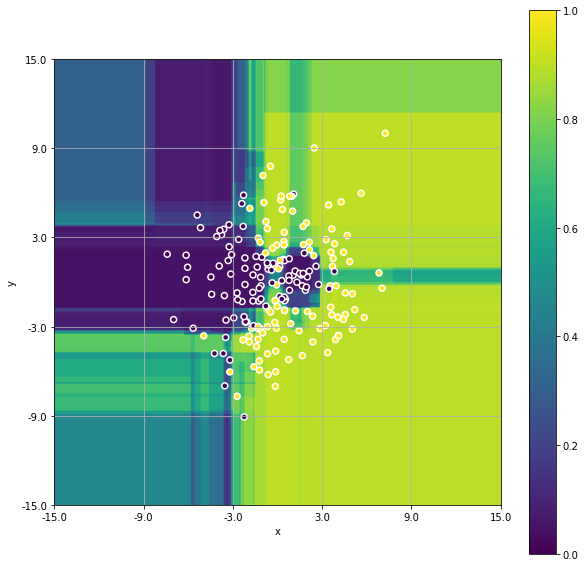

RandomForestRegressor
BANK DATASET
Train accuracy - 0.93
Test accuracy - 0.894
________________________________________________________________
________________________________________________________________
SYNTHETIC_DATASET
Train accuracy - 0.954
Test accuracy - 0.911


<ipython-input-6-2c719e7a6a7d>:32: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



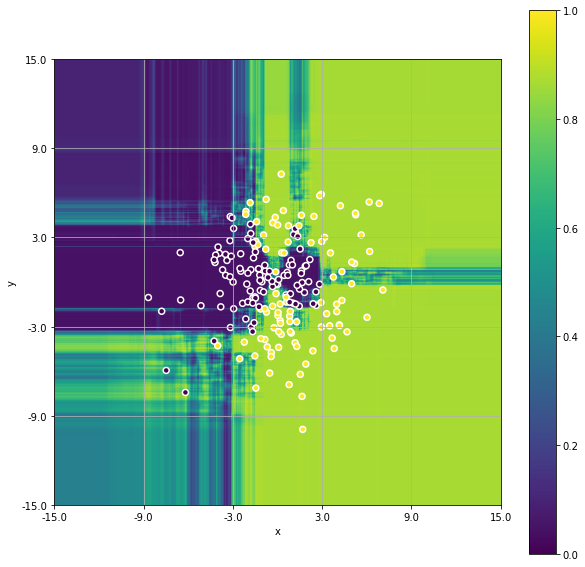

LinearRegression
BANK DATASET
Train accuracy - 0.847
Test accuracy - 0.842
________________________________________________________________
________________________________________________________________
SYNTHETIC_DATASET
Train accuracy - 0.72
Test accuracy - 0.719


<ipython-input-6-2c719e7a6a7d>:32: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



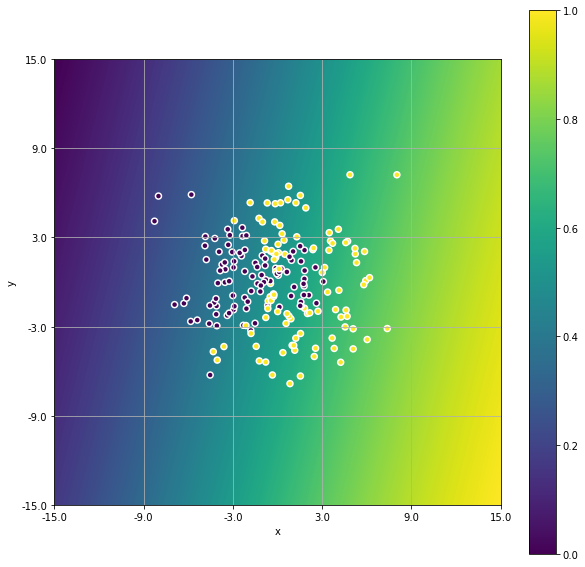

In [67]:
check_base_models(models, datasets)

#### 3. (2 балла) Мы разобрались с бустингом, теперь интересно посмотреть на совсем дикие комбинации моделей. Сравните результаты следующих моделей на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных.

Используйте логистическую регрессию, случайный лес и BaggingClassifier из sklearn.

- Случайный лес
- Бэггинг на деревьях (поставьте для базовых деревьев min_samples_leaf=1)
- Бэггинг на деревьях с обучением каждого дерева на подмножестве признаков (`max_features` около 0.6 в BaggingClassifier)
- Бэггинг, у которого базовой моделью является бустинг с большим числом деревьев (> 100)
- Бэггинг на логистических регрессиях

1) Какая из моделей имеет лучшее качество? С чем это связано?

2) Какая из моделей сильнее всего переобучается? Помогает ли бустингу ранняя остановка? 

3) Исправляет ли бэггинг переобученность бустинга с большим числом деревьев?

4) Что лучше: случайный лес или бэггинг на деревьях с сэмплированием признаков?

5) Если использовать деревья в качестве базового алгоритма, что лучше — бэггинг или бустинг? С чем это связано?

In [ ]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

#### 4. (2 балла) Сравните на этих данных любую из трёх популярных имплементаций градиентного бустинга (xgboost, lightgbm, catboost) с вашей реализацией. Подберите основные гиперпараметры (число деревьев, длина шага, глубина дерева/число листьев) для обоих методов. Получилось ли у вас победить библиотечные реализации на тестовых данных?

__Бонус (1 балл)__: современное развитие методов машинного обучения позволяет автоматизировать и оптимизировать подбор гиперпараметров. Воспользуйтесь для данной задачи одним из фреймворков для такого подбора - например, [hyperopt](https://github.com/hyperopt/hyperopt) или [optuna](https://github.com/optuna/optuna). Сравните также полученные данным методом модели с простым перебором гиперпараметров. 

In [ ]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

#### 5. (Бонус, 1 балл) В этом задании мы поговорим об интерпретации моделей.

Наша бустинговая модель способна возвращать вероятности для классов. Давайте попробуем оценить, насколько эти вероятности согласованы с реальностью. Для этого мы используем уже знакомый вам метод калибровочных кривых. Постройте калибровочные кривые для бустинговой модели и для логистической регрессии на обоих датасетах. Хорошо ли откалиброваны вероятности бустинга?

In [ ]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

Бустинг также позволяет рассчитать важность признаков в данных. Для этого существует много подходов, но мы обратимся к самому простому. Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить, после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так). Проделайте это, затем нарисуйте столбчатые диаграммы важности признаков для обоих датасетов. На соседних графиках нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики. Что можно сказать?

In [ ]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (на тех же параметрах!). Стало ли лучше?

In [ ]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

#### 6. (Бонус, 0.01 балла) Готовы ли вы в следующем году пойти ассистентом на этот курс и токсить на набор 19 года во флуде? 

Your answer: